Loading and preparing data...
Features used in model: 6 (5 pollutants + AQI)
Original X shape: (26124, 6, 6)
Reshaped X_mlp shape: (26124, 36) (Input Dimension: 36)
Target y shape: (26124, 1)

Training samples: 20899
Testing samples: 5225

--- MLP Model Architecture (Input Dim: 36) ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,617 (61.00 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 0 (0.00 B)


Starting Stacked MLP model training (50 epochs)...
Epoch 1/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0085 - val_loss: 1.3082e-04
Epoch 2/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6799e-04 - val_loss: 7.0086e-05
Epoch 3/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7052e-04 - val_loss: 6.0175e-05
Epoch 4/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.8781e-04 - val_loss: 4.4343e-05
Epoch 5/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4464e-04 - val_loss: 3.9967e-05
Epoch 6/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3203e-04 - val_loss: 3.5475e-05
Epoch 7/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4352e-04 - val_loss: 3.5163e-05
Epoch 8/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1542e-04 - val_loss: 5.1475e-05
Epoch 9/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3952e-04 - val_loss: 3.3191e-05
Epoch 10/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2649e-04 - val_loss: 6.5049e-05
Epoch 11/50

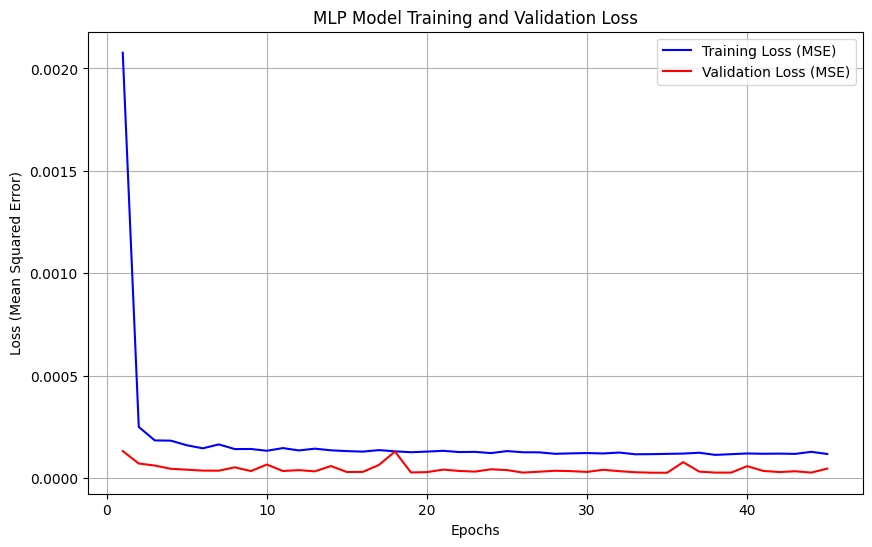

Loss graph displayed successfully.


In [ ]:
# Multi Layer Perception using only 5 primary pollutant features + AQI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import save_model, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import os

# --- 1. Configuration and Constants ---

N_INPUT = 6 # Number of historical timesteps to use for prediction (6 hours)
TEST_SIZE_RATIO = 0.2
MODEL_FILE = 'model_mlp_6f.keras'
SCALER_FILE = 'scaler_mlp_6f.pkl'
HISTORY_FILE = 'history_mlp_6f.pkl'

# --- 2. Utility Function: Create Sequences ---

def create_sequences(data, n_input, n_output, target_index):
 """
  Creates input sequences (X) and target outputs (y) for a time series dataset.
  """
 X, y = list(), list()
 for i in range(len(data)):
  end_ix = i + n_input
  out_end_ix = end_ix + n_output

  if out_end_ix > len(data):
   break

  seq_x = data[i:end_ix, :]
  seq_y = data[end_ix:out_end_ix, target_index]

  X.append(seq_x)
  y.append(seq_y)

 return np.array(X), np.array(y)

# --- 3. Data Preprocessing ---

print("Loading and preparing data...")
try:
    df = pd.read_csv('delhi_cleaned.csv')
except FileNotFoundError:
    print("Error: 'delhi_cleaned.csv' not found. Please ensure your data file is in the directory.")
    exit()

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d-%m-%Y %H:%M:%S')
df = df.set_index('Datetime')

features = [
 'PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'AQI'
]
df_data = df[features].copy()

data = df_data.values.astype('float32')

N_FEATURES = data.shape[1] # Should be 6
TARGET_FEATURE_INDEX = N_FEATURES - 1

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create input sequences (X) and targets (y)
X, y = create_sequences(scaled_data, N_INPUT, n_output=1, target_index=TARGET_FEATURE_INDEX)

# --- 4. Reshape for MLP (Flatten Timesteps and Features) ---
# New input shape: (samples, N_INPUT * N_FEATURES) = (samples, 6 * 6 = 36)
X_mlp = X.reshape((X.shape[0], N_INPUT * N_FEATURES))

print(f"Features used in model: {N_FEATURES} ({N_FEATURES - 1} pollutants + AQI)")
print(f"Original X shape: {X.shape}")
print(f"Reshaped X_mlp shape: {X_mlp.shape} (Input Dimension: {N_INPUT * N_FEATURES})")
print(f"Target y shape: {y.shape}")

# --- 5. Train-Test Split ---

split_index = int(len(X_mlp) * (1 - TEST_SIZE_RATIO))
X_train, X_test = X_mlp[:split_index], X_mlp[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- 6. Build and Train the Stacked MLP model (4 Hidden Layers) ---

input_dim = N_INPUT * N_FEATURES

model_mlp = Sequential()
# Input layer (flattened)
model_mlp.add(Input(shape=(input_dim,)))
model_mlp.add(Dense(128, activation='relu'))

# Hidden Layer 2
model_mlp.add(Dense(64, activation='relu'))

# Hidden Layer 3
model_mlp.add(Dense(32, activation='relu'))

# Hidden Layer 4
model_mlp.add(Dense(16, activation='relu'))

# Output layer
model_mlp.add(Dense(1))

model_mlp.compile(optimizer='adam', loss='mse')
print("\n--- MLP Model Architecture (Input Dim: 36) ---")
model_mlp.summary()

# Training the model with Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

print("\nStarting Stacked MLP model training (50 epochs)...")
history = model_mlp.fit(
 X_train,
 y_train,
 epochs=50,
 batch_size=32,
 verbose=1,
 validation_split=0.2, # 20% of training data used for validation during training
 callbacks=[early_stop]
)
print("MLP Model training complete.")

# Evaluation
y_pred_scaled = model_mlp.predict(X_test)
# Inverse scale AQI only
# Test Data
dummy_test = np.zeros((len(y_test), N_FEATURES))
dummy_test[:, TARGET_FEATURE_INDEX] = y_test.flatten()
y_test_original = scaler.inverse_transform(dummy_test)[:, TARGET_FEATURE_INDEX]

# Predicted Data
dummy_pred = np.zeros((len(y_pred_scaled), N_FEATURES))
dummy_pred[:, TARGET_FEATURE_INDEX] = y_pred_scaled.flatten()
y_pred_original = scaler.inverse_transform(dummy_pred)[:, TARGET_FEATURE_INDEX]

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Root Mean Squared Error (RMSE): {rmse:.6f} (scaled units)")
print(f"Mean Absolute Error (MAE): {mae:.6f} (scaled units)")

# --- 8. Save Model, Scaler, and History  ---
print("\n--- Saving Model and Scaler ---")
# Save the fitted scaler
with open(SCALER_FILE, 'wb') as f:
  pickle.dump(scaler, f)
print(f"Scaler saved to '{SCALER_FILE}'")

# Save the trained model structure and weights
model_mlp.save(MODEL_FILE)
print(f"Model saved to '{MODEL_FILE}'")

# Save the training history
with open(HISTORY_FILE, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved to '{HISTORY_FILE}'")


# --- 9. Plotting Training and Validation Loss ---
print("\n--- Generating Loss Plot ---")

history_dict = history.history
train_loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')

if train_loss and val_loss:
    epochs_ran = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_ran, train_loss, 'b-', label='Training Loss (MSE)')
    plt.plot(epochs_ran, val_loss, 'r-', label='Validation Loss (MSE)')
    plt.title('MLP Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Loss graph displayed successfully.")
else:
    print("Plot Skipped: 'loss' or 'val_loss' keys missing in history object.")


In [ ]:
# MLP Prediction Script for 5 Selected Pollutants + AQI (Total 6 features)
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pickle
import os

# --- Configuration (Must match the training script) ---
N_INPUT = 6   # Lookback window (6 hours)
N_FEATURES = 6 # Must be 6 (5 pollutants + AQI)
TARGET_FEATURE_INDEX = N_FEATURES - 1 # AQI is the last feature (index 5)

# The specific 5 pollutants + AQI used for training
SELECTED_FEATURES = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'AQI']

# --- Assumed Loaded Objects (Replace with your actual loaded objects if necessary) ---
# NOTE: In a real-world scenario, you would load the scaler and the model
# from saved files (e.g., 'scaler.pkl' and 'model_mlp.h5').

# Fallback/Dummy definitions for standalone execution (will be overwritten if run after training)
try:
    # Attempt to load the scaler if it was saved by the training script
    with open('scaler_mlp_6f.pkl', 'rb') as f:
        scaler = pickle.load(f)
except:
    print("Warning: Could not load scaler. Assuming a default MinMaxScaler setup.")
    # Initialize a dummy scaler if loading fails (will fail later if not properly trained)
    scaler = MinMaxScaler(feature_range=(0, 1))

# Helper function to map AQI to bucket
def get_bucket(aqi):
  """Maps AQI value to the standard bucket category."""
  aqi = round(aqi)
  if 0 <= aqi <= 50: return "Good"
  elif 51 <= aqi <= 100: return "Satisfactory"
  elif 101 <= aqi <= 200: return "Moderate"
  elif 201 <= aqi <= 300: return "Poor"
  elif 301 <= aqi <= 400: return "Very Poor"
  elif 401 <= aqi <= 999: return "Severe"
  else: return "Invalid"

# Helper function to inverse transform the scaled AQI prediction
def inverse_transform_aqi(scaled_aqi, scaler, n_features):
  """Inverse transforms the scaled AQI prediction back to its original magnitude."""
  # Create a dummy array with 'n_features' (6) columns
  dummy = np.zeros((1, n_features))
  # Place the scaled AQI value in the correct target column (the last one, index 5)
  dummy[0, TARGET_FEATURE_INDEX] = scaled_aqi

  # Inverse transform the dummy array and extract the AQI column
  return scaler.inverse_transform(dummy)[0, TARGET_FEATURE_INDEX]


hourly_features_reduced = [] # List to store the 6 features (5 pollutants + AQI) for 6 hours

print("\n--- Enter 6 feature values for last 6 hours (5 Pollutants + AQI) ---")
print(f"Features order: {', '.join(SELECTED_FEATURES)}")
print("Enter them comma-separated (e.g., PM2.5, PM10, O3, CO, NO2, AQI)")

# Using the new 6-feature sample input list provided by the user
sample_inputs = [
"211.51,340.66,37.08,15.24,34.35,456",
"191.12,257.4,38.4,13.11,34.38,450",
"218.44,351.01,44.73,18.35,38.42,446",
"296.8,600.95,47.76,16.67,49.12,475",
"336.43,714.63,46.31,12.17,56.44,480",
"326.64,691.84,44.33,9.03,47.73,484"
]

try:
  for h in range(N_INPUT):
    # Using the streamlined sample data directly
    print(f"\nHour {h+1} features (6 values): (Using sample data: {sample_inputs[h]})")
    values = [float(x.strip()) for x in sample_inputs[h].split(",")]

    if len(values) != N_FEATURES:
      raise ValueError(f"Expected {N_FEATURES} values, got {len(values)}. (5 pollutants + AQI)")

    hourly_features_reduced.append(values)
except Exception as e:
  print(f"\n[Error during input simulation]: {e}")
  # Fallback to interactive input
  print("\n[ERROR] Simulation failed. Enter 6 features manually for the last 6 hours.")
  for h in range(N_INPUT):
    values = input(f"\nHour {h+1} features (PM2.5, PM10, O3, CO, NO2, AQI): ")
    values = [float(x.strip()) for x in values.split(",")]
    hourly_features_reduced.append(values)


# 7. Prepare Input for MLP Model

# 1. Scale all 6 hours of 6 features using the fitted scaler
scaled_input = scaler.transform(hourly_features_reduced) # Shape: (6, 6)

# 2. Reshape into (1, N_INPUT * N_FEATURES)
# MLP requires the input to be flattened: (6 timesteps * 6 features) = 36
X_input = scaled_input.reshape((1, N_INPUT * N_FEATURES))
# Now X_input shape is (1, 36)

# 8. Predict Next Hour AQI
# Assume 'model_mlp' is the loaded/trained model object from the training script
pred_scaled = model_mlp.predict(X_input, verbose=0)

# Inverse scale AQI back to original units (needs 6 dummy columns)
pred_aqi = inverse_transform_aqi(
  pred_scaled[0, 0], # pred_scaled is shape (1, 1), so [0, 0] gives the scalar
  scaler,
  N_FEATURES # Use the reduced feature count: 6
)

# 9. Results
print("\n" + "="*50)
print(f"Prediction for Hour 7 (Based on last {N_INPUT} hours)")
print("="*50)
print(f"Features used: {', '.join(SELECTED_FEATURES)}")
print(f"Input Dimension: {N_INPUT} hours * {N_FEATURES} features = {N_INPUT * N_FEATURES}")
print(f"Last Known AQI (Hour 6 Input): {hourly_features_reduced[-1][-1]:.2f} → Bucket: {get_bucket(hourly_features_reduced[-1][-1])}")
print(f"Predicted Next Hour AQI:   {pred_aqi:.2f} → Bucket: {get_bucket(pred_aqi)}")
print("="*50)



--- Enter 6 feature values for last 6 hours (5 Pollutants + AQI) ---
Features order: PM2.5, PM10, O3, CO, NO2, AQI
Enter them comma-separated (e.g., PM2.5, PM10, O3, CO, NO2, AQI)

Hour 1 features (6 values): (Using sample data: 211.51,340.66,37.08,15.24,34.35,456)

Hour 2 features (6 values): (Using sample data: 191.12,257.4,38.4,13.11,34.38,450)

Hour 3 features (6 values): (Using sample data: 218.44,351.01,44.73,18.35,38.42,446)

Hour 4 features (6 values): (Using sample data: 296.8,600.95,47.76,16.67,49.12,475)

Hour 5 features (6 values): (Using sample data: 336.43,714.63,46.31,12.17,56.44,480)

Hour 6 features (6 values): (Using sample data: 326.64,691.84,44.33,9.03,47.73,484)

Prediction for Hour 7 (Based on last 6 hours)
Features used: PM2.5, PM10, O3, CO, NO2, AQI
Input Dimension: 6 hours * 6 features = 36
Last Known AQI (Hour 6 Input): 484.00 → Bucket: Severe
Predicted Next Hour AQI:   483.05 → Bucket: Severe


Loading and preparing data...
Cleaned Data Size: 26130 hours for Delhi.
Scaler saved to 'scaler_6f.pkl'
Features used in model: 6 (5 pollutants + AQI)

Sequence Dimensions: X shape (26124, 6, 6) (Input: 6 timesteps, 6 features), y shape (26124, 1)
Train/Test Split: 20899 train, 5225 test

--- Training Stacked LSTM ---
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


654/654 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0122 - val_loss: 2.5713e-04
Epoch 2/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019 - val_loss: 2.4449e-04
Epoch 3/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0013 - val_loss: 2.8931e-04
Epoch 4/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - val_loss: 2.4989e-04
Epoch 5/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.6747e-04 - val_loss: 1.8390e-04
Epoch 6/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 9.7457e-04 - val_loss: 1.8290e-04
Epoch 7/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 9.4549e-04 - val_loss: 2.0522e-04
Epoch 8/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.9150e-04 - val_loss: 2.0522e-04
Epoch 9/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.8796e-04 - val_loss: 2.0548e-04
Epoch 10/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.5982e-04 - val_loss: 2.7166e-04
Epoch 11/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 8.3264e-04 - val_loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 100)         │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,155 (856.08 KB)

 Trainable params: 73,051 (285.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,104 (570.72 KB)

164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Root Mean Squared Error (RMSE): 4.903612 (scaled units)
Mean Absolute Error (MAE): 3.736837 (scaled units)

--- Generating Loss Plot ---


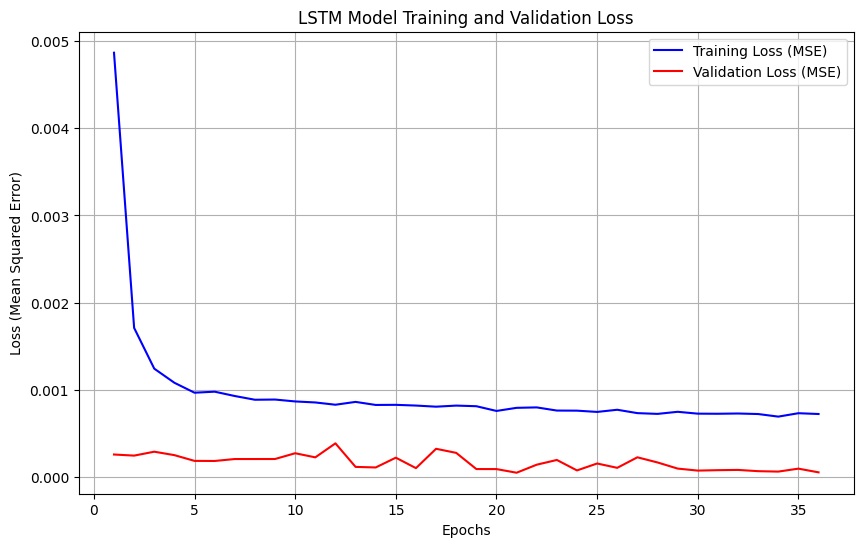

Loss graph displayed successfully.


In [ ]:
#-------------------------- IMP ---------------------------
# Stacked LSTM Training Script for 5 Pollutants + AQI (Total 6 features)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os

# --- Configuration ---
CITY_NAME = 'Delhi'
N_INPUT = 6 # Lookback window (6 hours)
MODEL_FILE = 'model_lstm_6f.keras'
SCALER_FILE = 'scaler_lstm_6f.pkl'
HISTORY_FILE = 'history_lstm_6f.pkl'
TARGET_FEATURE_INDEX = 5 # AQI is the last feature (index 5)
TEST_SIZE_RATIO = 0.2

# Features used for the model
FEATURES = ['PM2.5','PM10','O3','CO','NO2','AQI']

# 1. Data Cleaning and Preprocessing (Load and scale data)

print("Loading and preparing data...")
try:
    df = pd.read_csv("delhi_cleaned.csv", parse_dates=['Date'])
except FileNotFoundError:
    print("Error: 'delhi_cleaned.csv' not found. Please ensure your data file is in the directory.")
    exit()

df_city = df[df['City'] == CITY_NAME].copy()
df_city['Time'] = pd.to_datetime(df_city['Date'] + ' ' + df_city['Time'], format='%d-%m-%Y %H:%M:%S')
df_city = df_city.set_index('Time')
df_city = df_city.sort_index()

df_city = df_city[FEATURES]
df_city = df_city.interpolate(method='linear')
df_city.dropna(inplace=True)

print(f"Cleaned Data Size: {df_city.shape[0]} hours for {CITY_NAME}.")

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_city.values)

# --- SAVING SCALER ---
with open(SCALER_FILE, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved to '{SCALER_FILE}'")

N_FEATURES = scaled_data.shape[1] # Should be 6

print(f"Features used in model: {N_FEATURES} ({N_FEATURES - 1} pollutants + AQI)")


# 2. Sequence Creation

def create_sequences(data, n_input, target_index, n_output=1):
    X, y = list(), list()
    for i in range(len(data) - n_input - n_output + 1):
        end_ix = i + n_input
        out_end_ix = end_ix + n_output
        seq_x = data[i:end_ix, :]
        # Target is the AQI value (index 5) N_INPUT steps ahead
        seq_y = data[end_ix:out_end_ix, target_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, N_INPUT, TARGET_FEATURE_INDEX)

# 3. Train/Test Split
train_size = int(len(X) * (1 - TEST_SIZE_RATIO))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\nSequence Dimensions: X shape {X.shape} (Input: {N_INPUT} timesteps, {N_FEATURES} features), y shape {y.shape}")
print(f"Train/Test Split: {len(X_train)} train, {len(X_test)} test")

# 4. Build and Train Stacked LSTM

model_lstm = Sequential()
# Input shape is (N_INPUT=6, N_FEATURES=6)
model_lstm.add(LSTM(100, activation='relu', input_shape=(N_INPUT, N_FEATURES), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dropout(0.3))

model_lstm.add(Dense(1)) # Output layer for the single AQI prediction

model_lstm.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min', restore_best_weights=True)


print("\n--- Training Stacked LSTM ---")
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)
print("Training Complete.")

# 5. Model Summary, Save, and Evaluation

# Save Model and History
model_lstm.save(MODEL_FILE)
print(f"Model saved to '{MODEL_FILE}'")

with open(HISTORY_FILE, 'wb') as f:
    pickle.dump(history_lstm.history, f)
print(f"Training history saved to '{HISTORY_FILE}'")


print("\n--- LSTM Architecture ---")
model_lstm.summary()

# Evaluation
# Predict directly in scaled values
y_pred_scaled = model_lstm.predict(X_test)

dummy_test = np.zeros((len(y_test), N_FEATURES))
dummy_test[:, TARGET_FEATURE_INDEX] = y_test.flatten()
y_test_original = scaler.inverse_transform(dummy_test)[:, TARGET_FEATURE_INDEX]

# Predicted Data
dummy_pred = np.zeros((len(y_pred_scaled), N_FEATURES))
dummy_pred[:, TARGET_FEATURE_INDEX] = y_pred_scaled.flatten()
y_pred_original = scaler.inverse_transform(dummy_pred)[:, TARGET_FEATURE_INDEX]

rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Root Mean Squared Error (RMSE): {rmse:.6f} (scaled units)")
print(f"Mean Absolute Error (MAE): {mae:.6f} (scaled units)")


# 6. Plotting Training and Validation Loss
print("\n--- Generating Loss Plot ---")

history_dict = history_lstm.history
train_loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')

if train_loss and val_loss:
    epochs_ran = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs_ran, train_loss, 'b-', label='Training Loss (MSE)')
    plt.plot(epochs_ran, val_loss, 'r-', label='Validation Loss (MSE)')
    plt.title('LSTM Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (Mean Squared Error)')
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Loss graph displayed successfully.")
else:
    print("Plot Skipped: 'loss' or 'val_loss' keys missing in history object.")


In [ ]:
#-------------------------- IMP ---------------------------
# LSTM Prediction Script for 5 Pollutants + AQI (Total 6 features)
import numpy as np
import pickle
import os
from tensorflow.keras.models import load_model # Used for loading the model

# --- Configuration ---
N_INPUT = 6 # Lookback window (6 hours)
N_FEATURES = 6 # Must be 6 (5 pollutants + AQI)
TARGET_FEATURE_INDEX = N_FEATURES - 1 # AQI is the last feature (index 5)

# Features used for the model (Must match the training script)
FEATURES = ['PM2.5','PM10','O3','CO','NO2','AQI']

# --- Load Model and Scaler ---
try:
    # Load the fitted scaler
    with open('scaler_lstm_6f.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("Successfully loaded 'scaler_lstm_6f.pkl'")
except Exception as e:
    raise RuntimeError(f"FATAL ERROR: Could not load 'scaler_lstm_6f.pkl'. Ensure the training script was run successfully. Details: {e}")

try:
    # Load the trained Keras model
    model_lstm = load_model('model_lstm_6f.keras')
    print("Successfully loaded 'model_lstm_6f.keras'")
except Exception as e:
    raise RuntimeError(f"FATAL ERROR: Could not load 'model_lstm_6f.keras'. Ensure the training script was run successfully. Details: {e}")


# Helper function to map AQI to bucket
def get_bucket(aqi):
  """Maps AQI value to the standard bucket category."""
  aqi = round(aqi)
  if 0 <= aqi <= 50: return "Good"
  elif 51 <= aqi <= 100: return "Satisfactory"
  elif 101 <= aqi <= 200: return "Moderate"
  elif 201 <= aqi <= 300: return "Poor"
  elif 301 <= aqi <= 400: return "Very Poor"
  elif 401 <= aqi <= 999: return "Severe"
  else: return "Invalid"

# Helper function to inverse transform the scaled AQI prediction
def inverse_transform_aqi(scaled_aqi, scaler, num_features):
  """Inverse transforms the scaled AQI prediction back to its original magnitude."""
  dummy = np.zeros((1, num_features))
  # Place the scaled AQI value in the correct target column (the last one, index 5)
  dummy[0, TARGET_FEATURE_INDEX] = scaled_aqi
  return scaler.inverse_transform(dummy)[0, TARGET_FEATURE_INDEX]


# ----------------------------------------------------------------------
# 6. Prepare Input Data (Sample data provided for demonstration)
# ----------------------------------------------------------------------

hourly_features_full = [] # List to store the 6 features for 6 hours

print("\n--- Enter 6 feature values for last 6 hours (5 Pollutants + AQI) ---")
print(f"Features order: {', '.join(FEATURES)}")
print("Make sure the last value entered for each hour is the **Actual AQI** for that hour.")

# Sample input data (6 hours, 6 features each)
sample_inputs = [
"211.51,340.66,37.08,15.24,34.35,456",
"191.12,257.4,38.4,13.11,34.38,450",
"218.44,351.01,44.73,18.35,38.42,446",
"296.8,600.95,47.76,16.67,49.12,475",
"336.43,714.63,46.31,12.17,56.44,480",
"326.64,691.84,44.33,9.03,47.73,484"
]

try:
  for h in range(N_INPUT):
    print(f"\nHour {h+1} features (6 values): (Using sample data: {sample_inputs[h]})")
    values = [float(x.strip()) for x in sample_inputs[h].split(",")]

    if len(values) != N_FEATURES:
      raise ValueError(f"Expected {N_FEATURES} values, got {len(values)}. (5 pollutants + AQI)")

    hourly_features_full.append(values)
except Exception as e:
  print(f"\n[Error during input simulation]: {e}")
  print("\n[ERROR] Simulation failed. Enter 6 features manually for the last 6 hours.")
  # Fallback to interactive input if simulation fails
  for h in range(N_INPUT):
    values = input(f"\nHour {h+1} features ({', '.join(FEATURES)}): ")
    values = [float(x.strip()) for x in values.split(",")]
    hourly_features_full.append(values)


# 7. Prepare Input for LSTM Model

# 1. Scale all 6 hours of 6 features using the fitted scaler
scaled_input = scaler.transform(hourly_features_full)

# 2. Reshape into (1, timesteps=6, features=6) for LSTM
X_input = scaled_input.reshape((1, N_INPUT, N_FEATURES))

# 8. Predict Next Hour AQI

pred_scaled = model_lstm.predict(X_input, verbose=0)

# Inverse scale AQI back to original units
pred_aqi = inverse_transform_aqi(
  pred_scaled[0, 0],
  scaler,
  N_FEATURES
)


print("\n" + "="*50)
print(f"Prediction for Hour 7 (Based on last {N_INPUT} hours)")
print("="*50)
print(f"Model: Stacked LSTM | Input: {N_FEATURES} features")
print(f"Input Dimension: (1, {N_INPUT}, {N_FEATURES})")
print(f"Last Known AQI (Hour 6 Input): {hourly_features_full[-1][-1]:.2f} → Bucket: {get_bucket(hourly_features_full[-1][-1])}")
print(f"Predicted Next Hour AQI:  {pred_aqi:.2f} → Bucket: {get_bucket(pred_aqi)}")
print("="*50)


Successfully loaded 'scaler_lstm_6f.pkl'
Successfully loaded 'model_lstm_6f.keras'

--- Enter 6 feature values for last 6 hours (5 Pollutants + AQI) ---
Features order: PM2.5, PM10, O3, CO, NO2, AQI
Make sure the last value entered for each hour is the **Actual AQI** for that hour.

Hour 1 features (6 values): (Using sample data: 211.51,340.66,37.08,15.24,34.35,456)

Hour 2 features (6 values): (Using sample data: 191.12,257.4,38.4,13.11,34.38,450)

Hour 3 features (6 values): (Using sample data: 218.44,351.01,44.73,18.35,38.42,446)

Hour 4 features (6 values): (Using sample data: 296.8,600.95,47.76,16.67,49.12,475)

Hour 5 features (6 values): (Using sample data: 336.43,714.63,46.31,12.17,56.44,480)

Hour 6 features (6 values): (Using sample data: 326.64,691.84,44.33,9.03,47.73,484)

Prediction for Hour 7 (Based on last 6 hours)
Model: Stacked LSTM | Input: 6 features
Input Dimension: (1, 6, 6)
Last Known AQI (Hour 6 Input): 484.00 → Bucket: Severe
Predicted Next Hour AQI:  482.35 → B